# Necessary Installations

In [ ]:
#the following installations only need to be completed once
!pip install pandas numpy
!pip install scikit-learn
!pip install dash
!pip install dash-daq
!pip install plotly
!pip install ipywidgets
!pip install notebook
jupyter nbextension enable --py widgetsnbextension

# Importing Libraries

In [163]:
# Essential imports
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# Random Forest Necessary Imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier, plot_tree


# All relevant dash imports
import dash
from dash import dcc, html, ctx
from dash.dependencies import Input, Output
from dash.dash_table import DataTable

# Additional imports to display figures correctly
import plotly.graph_objects as go
from ipywidgets import widgets
from IPython.display import display
import io  # For capturing df.info() output

import webbrowser
from threading import Timer
import dtreeviz

ImportError: cannot import name 'dtreeviz' from 'dtreeviz.trees' (C:\Users\adamr\anaconda3\lib\site-packages\dtreeviz\trees.py)

# Application Code

In [142]:
# Concatenation of Values and Validation Tree Implemented
def generate_dynamic_rf_classifier_visualizer(rfclf, X_train, X_test, y_train, y_test, port_number=8062):
    le = LabelEncoder()
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_test = le.fit_transform(y_test)
    # Convert the dataframes provided to prevent any warnings from popping up
    
    feature_names = X_train.columns
    # Extract feature names
    
    app = dash.Dash(__name__)
    # Initialize the Dash app
    
    list_of_selected_nodes = [{} for _ in range(len(rfclf.estimators_))]
    
    # Defines a binary search tree node class with a DataFrame
    class Node:
        def __init__(self, value, pos, color, data, conf_matrix, path):
            self.value = value
            self.pos = pos
            self.color = color
            self.data = data
            self.conf_matrix = conf_matrix
            self.path = path
            self.left = None
            self.right = None
    
    # Function to create the tree structure
    def create_bst_with_positions(node_list, tree, X_test, y_predictions, y_true, feature_names, node_id=0, G=None, path=""):
        if node_id == -1:
            return None
        
        if G is None:
            G = nx.DiGraph()
    
        # Define node attributes
        if tree.tree_.feature[node_id] == -2:
            color = 'green'
            # Since leaves are normally associated with the color green, all leaf nodes are colored green in the figure, 
            # and blue otherwise
            value = f"Leaf ID: {node_id}"
            # To ensure each leaf node has a unique value, their node_id is taken; researchers may also look at the 
            # tree.tree_.feature[node_id] value for further study.
        else:
            color = 'blue'
            feature = tree.tree_.feature[node_id]
            threshold = tree.tree_.threshold[node_id]
            condition = f"{feature_names[feature]} <= {threshold:.2f}"
            anticondition = condition.replace("<=", ">")
            # Since the condition of these trees always reads feature <= threshold, the anticondition would simply use the > 
            # sign for right children
            
            if path == "":
                path += f"{condition}"
            else:
                path += f" -> {condition}"
            value = condition
            # Since each non-leaf node has a distinct splitting condition and since this condition is of significance to users, 
            # this serves as the display value for the figure to be displayed
    
        
        samples_in_node = (np.where(tree.apply(X_test) == node_id))[0]
        data = pd.DataFrame(X_test[samples_in_node], columns=feature_names)
        # Extract samples and create node data
        
        data['Predicted'] = y_predictions[samples_in_node]
        data['True'] = y_true[samples_in_node]
        conf_matrix = confusion_matrix(data['True'], data['Predicted'], labels=np.unique(y_true))
        # Append the y_prediction values and y_true values to the datapoints using the samples_in_node indices to later display these values
        # and generate confusion matrices in the visualizations
    
        # Add node to the graph and list
        G.add_node(node_id)
        node = Node(value, None, color, data, conf_matrix, path)
        node_list.append(node)
    
        # Recursion for children
        left_child_id = tree.tree_.children_left[node_id]
        right_child_id = tree.tree_.children_right[node_id]
    
        if left_child_id != -1:
            G.add_edge(node_id, left_child_id)
            node.left = create_bst_with_positions(node_list, tree, X_test, y_predictions, y_true, feature_names, left_child_id, G, path)
    
        if right_child_id != -1:
            G.add_edge(node_id, right_child_id)
            node.right = create_bst_with_positions(node_list, tree, X_test, y_predictions, y_true, feature_names, right_child_id, G, path)
    
        return node, G
    
    def smart_hierarchy_pos(G, root=None, vert_gap=0.2, xcenter=0.5):
        def count_leaves(node):
            # Count the number of leaf nodes in the subtree rooted at the current node
            children = list(G.neighbors(node))
            if not children:  # Leaf node
                return 1
            return sum(count_leaves(child) for child in children)
    
        def assign_positions(node, depth, x_min, x_max, pos):
            # Recursively assign positions to nodes.
            pos[node] = ((x_min + x_max) / 2, -depth * vert_gap)
    
            children = list(G.neighbors(node))
            if children:
                total_leaves = sum(count_leaves(child) for child in children)
                x_start = x_min
                for child in children:
                    child_leaves = count_leaves(child)
                    child_width = (child_leaves / total_leaves) * (x_max - x_min)
                    assign_positions(child, depth + 1, x_start, x_start + child_width, pos)
                    x_start += child_width
    
        if root is None:
            root = next(iter(nx.topological_sort(G)))
    
        pos = {}
        total_leaves = count_leaves(root)
        assign_positions(root, 0, 0, total_leaves, pos)
        return pos

    # Function to assign positions using NetworkX layout
    def assign_positions_to_nodes(node_list, G):
        positions = smart_hierarchy_pos(G, root=0)  # NetworkX layout calculation
        for node in node_list:
            if node_list.index(node) in positions:
                node.pos = positions[node_list.index(node)]
    
    def create_figure_for_tree(tree, y_predictions):
        y_predictions = tree.predict(X_test_np)
        nodes = []
        
        bst_root, graph = create_bst_with_positions(nodes, tree, X_test_np, y_predictions, y_test, feature_names)
        # Assign positions to nodes
        assign_positions_to_nodes(nodes, graph)
        
        
        # bst_root = create_bst_from_tree(nodes, tree, X_test_np, y_predictions, y_test)
        # Build the current decision tree passed in and store its nodes in the nodes list
    
        fig = go.Figure()
    
        for node in nodes:
            x, y = node.pos
            value = node.value
            color = node.color
            # Set the position, value, and color of the nodes first
    
            hover_text = (
                f"{value}<br>"
                f"Path: {node.path}<br>"
                f"Number of Samples: {len(node.data)}<br>"
                f"Confusion Matrix:<br>{node.conf_matrix}"
            )
            # Set the hover data to include the value, path, number of test datapoints
            # contained in this value, and the confusion matrix
    
            fig.add_trace(go.Scatter(
                x=[x], y=[y],
                mode='markers+text',
                marker=dict(size=10, color=color),
                text=[value],
                textposition='middle center',
                hovertext=hover_text,
                hoverinfo='text'
            ))
            # Create a point for the current node with the information set above
        
        for e in graph.edges:
            x0, y0 = nodes[e[0]].pos
            x1, y1 = nodes[e[1]].pos
            fig.add_trace(go.Scatter(
                x=[x0, x1], y=[y0, y1],
                mode='lines',
                line=dict(color='black', shape='linear')
            ))
        
        fig.update_layout(
            title='Decision Tree Visualization',
            showlegend=False,
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            height=1200,
            width=1600,
        )
        # Once the nodes are drawn, please update the whole figure so it fits to the screen
    
        return fig, nodes
    
    app.layout = html.Div([
        dcc.Tabs(
            id="tree-tabs",
            children=[dcc.Tab(label=f"Tree {i + 1}", value=str(i)) for i in range(len(rfclf.estimators_))],
            value='0'
        ),
        html.Div(
            [
                html.Button("Clear Node Selection", id='clear-button', style={
                    'fontSize': '24px',
                    'padding': '20px 40px',
                    'backgroundColor': '#ff4d4f',
                    'color': 'white',
                    'border': 'none',
                    'borderRadius': '5px',
                    'cursor': 'pointer',
                })
            ],
            style={
                'display': 'flex',
                'justifyContent': 'center',
                'margin-top': '50px'
            }
        ),
        html.Div([
            html.Hr(),
            html.H3("Nodes Added"),
            html.Pre(id='nodes-added'),
        ]),
        html.Div(
            [
                dcc.Graph(id='bst-graph', config={"modeBarButtonsToAdd": ["select2d", "lasso2d"]}, clear_on_unhover=True)
            ],
            style={
                'display': 'flex',
                'justifyContent': 'center',
            }
        ),
        html.Div([
            html.Hr(),
            html.H3("Info Output"),
            html.Pre(id='node-info-output'),
        ]),
        html.Div([
            html.Hr(),
            html.H3("Describe Output"),
            html.Div(id='node-describe'),
        ]),
        html.Div([
            html.Hr(),
            html.H3("Node Data"),
            html.Div(id='node-dataframe'),
        ]),
        html.Div(
            [
                html.Button("Save Data", id='save-button', style={
                    'fontSize': '24px',
                    'padding': '20px 40px',
                    'backgroundColor': '#4dff4f',
                    'color': 'white',
                    'border': 'none',
                    'borderRadius': '5px',
                    'cursor': 'pointer',
                })
            ],
            style={
                'display': 'flex',
                'justifyContent': 'center',
                'margin-top': '50px'
            }
        ),
        html.Div([
            html.Hr(),
            html.H3("Model Validation"),
            dcc.Graph(id='confusion-matrix-graph'),
        ]),
    ])
    
    @app.callback(
        Output('nodes-added', 'children'),
        Output('bst-graph', 'figure'),
        Output('node-info-output', 'children'),
        Output('node-describe', 'children'),
        Output('node-dataframe', 'children'),
        Output('confusion-matrix-graph', 'figure'),  # Output for confusion matrix graph
        Input('tree-tabs', 'value'),
        Input('bst-graph', 'clickData'),
        Input('bst-graph', 'selectedData'),  # Add selectedData as an input
        Input('clear-button', 'n_clicks'),
        Input('save-button', 'n_clicks'),
    )
    # The display of essentially the entire application changes whenever either the tab changes, either the clear or save button is clicked, or new node is selected from the tree
    def update_tree_and_node_info(tab_index, clickData, selectedData, clear_clicks, save_clicks):
        tab_index = int(tab_index)
        tree = rfclf.estimators_[tab_index]
        fig, nodes = create_figure_for_tree(tree, tree.predict(X_test_np))
        # Upon render, the callback determines which tab is currently selected (1st tab as default) and generates the corresponding decision tree and saved the nodes from the tree
        
        empty_figure = go.Figure()
        empty_figure.update_layout(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            annotations=[
                dict(
                    text="No data available",
                    x=0.5,
                    y=0.5,
                    xref="paper",
                    yref="paper",
                    showarrow=False,
                    font=dict(size=20)
                )
            ]
        )
        # Initializes an empty figure that displays for the confusion matrix figure whenever there are no nodes selected for a tree 
        
        triggered = ctx.triggered_id
        # takes the id of the element that was selected within the display and completes behavior based on this input
    
        # If the clear button is clicked, all items asides from the decision tree figure are reset and are returned, preventing the behavior below
        if triggered == 'clear-button':
            list_of_selected_nodes[tab_index] = {}
            return '', fig, '', '', '', empty_figure
        
    
        # If the clear button is NOT clicked, the trigger is checked in case points from the bst-graph were selected or the save button was clicked
        selected_nodes = {}
        if triggered == 'bst-graph' and selectedData and 'points' in selectedData:
            selected_points = [point['text'] for point in selectedData['points']]
            # Extract nodes from points selected with box/lasso select
            for node in nodes:
                if node.value in selected_points:
                    selected_nodes[node.value] = node.data
             # Add all of the nodes just selected to the selected nodes dictionary       
            
        elif triggered == 'bst-graph' and clickData and 'points' in clickData:
            node_value = clickData['points'][0]['text']
            # Extracts the single node selected via click
    
            for node in nodes:
                if node_value == node.value:
                    selected_nodes[node_value] = node.data
            # Adds the node just selected to the selected nodes dictionary  
    
        list_of_selected_nodes[tab_index].update(selected_nodes)
        # For the list of currently selected nodes for a tab, the newly selected nodes are added to the mix       
        
        concatenated_dataframes = None
        if list_of_selected_nodes[tab_index]:
            concatenated_dataframes = pd.concat(list_of_selected_nodes[tab_index].values())
        # Once the newly selected nodes are added, the concatenated_dataframes are updated
    
        if concatenated_dataframes is not None:
            key_list = list(list_of_selected_nodes[tab_index].keys())
            nodes_added_display = ' '.join([f'{key} has been added' for key in key_list])
            # Display all of the nodes that have been current selected for the current tab
            
            buffer = io.StringIO()
            concatenated_dataframes.info(buf=buffer)
            info_output = buffer.getvalue()
            # Update the output for the df.info() to include the new selected nodes
    
            describe_df = concatenated_dataframes.describe().reset_index()
            describe_df.rename(columns={'index': 'Statistic'}, inplace=True)
            # Update the output for the df.describe() dataframe
        
            describe_table = DataTable(
                columns=[{"name": i, "id": i} for i in describe_df.columns],
                data=describe_df.to_dict('records'),
            )
            # Creates a Dash DataTable for the describe output
            
            dataframe_table = DataTable(
                columns=[{"name": i, "id": i} for i in concatenated_dataframes.columns],
                data=concatenated_dataframes.to_dict('records'),
            )
            # Creates a Dash DataTable for the full dataframe
            
            cm = confusion_matrix(
                concatenated_dataframes['True'],
                concatenated_dataframes['Predicted'],
                labels=np.unique(y_test)
            )
            cm_fig = go.Figure(data=go.Heatmap(
                z=cm,
                x=le.inverse_transform(np.unique(y_test)),  # Class names on x-axis
                y=le.inverse_transform(np.unique(y_test)),  # Class names on y-axis
                colorscale='Viridis'
            ))
            cm_fig.update_layout(
                title="Confusion Matrix of Selected Data Points",
                xaxis_title="Predicted Labels",
                yaxis_title="True Labels"
            )
            # Update the confusion matrix displayed
            
            if triggered == 'save-button':
                with open(f'dt{tab_index}_dataframe_info.txt', 'w') as file:
                    file.write(info_output)
                describe_df.to_csv(f'dt{tab_index}_describe_df.csv',index=False)
                concatenated_dataframes.to_csv(f'dt{tab_index}_concatenated_dataframes.csv',index=False)
            # When the save button is clicked, the text within all three visualizations is saved to file
        else:
            nodes_added_display = ''
            info_output = ''
            describe_table = ''
            dataframe_table = ''
            cm_fig = empty_figure
            # Save for the decision tree figure, display default/empty values for the remaining values if no nodes have been selected
    
        return nodes_added_display, fig, info_output, describe_table, dataframe_table, cm_fig
    # This function powers the interactivity of the software, regenerating information whenever any new information is considered
    
    # Function to open a new browser tab
    def open_browser():
        webbrowser.open(f'http://localhost:{port_number}')

    # Start the Dash app in a new thread
    Timer(1, open_browser).start()
    
    # In the case of unexpected errors, since the application is run within the Jupyter Notebook, the application is run in debug mode and is available at http://localhost:{port_number} for access
    app.run_server(debug=True, port=port_number)

# 3 Datasets

## Dataset 1: Iris Dataset

In [111]:
# Dataset containing 3 different types of irises' (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 Pandas DataFrame

In [5]:
# To test the general functionality, load and prepare the iris dataset
iris = sns.load_dataset('iris')
X_iris = iris.drop('species', axis=1)
y_iris = iris['species']
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)

# Train a random forest based on the iris dataset
rfclf_iris = RandomForestClassifier(n_estimators=10, random_state=42)
rfclf_iris.fit(X_train_iris, y_train_iris)

RandomForestClassifier(n_estimators=10, random_state=42)

## Dataset 2: Breast Cancer Wisconsin Dataset

In [119]:
from sklearn.datasets import load_breast_cancer 
X_bc, y_bc = load_breast_cancer(return_X_y=True, as_frame=True)

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size=0.3, random_state=42)
rfclf_bc = RandomForestClassifier(n_estimators=10, random_state=42)
rfclf_bc.fit(X_train_bc, y_train_bc)

RandomForestClassifier(n_estimators=10, random_state=42)

## Dataset 3: Human Activity Recognition (HAR) Dataset

In [109]:
# Dataset containing the smartphone sensor data of users with the intention of predicting their current activity 
# (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) stored in a 10299 × 561 Pandas DataFrame

In [96]:
har = fetch_openml('HAR')
X_har, y_har = har.data, har.target

X_train_har, X_test_har, y_train_har, y_test_har = train_test_split(X_har, y_har, test_size=0.3, random_state=42)
rfclf_har = RandomForestClassifier(n_estimators=10, random_state=42)
rfclf_har.fit(X_train_har, y_train_har)

# Using Application on Datasets

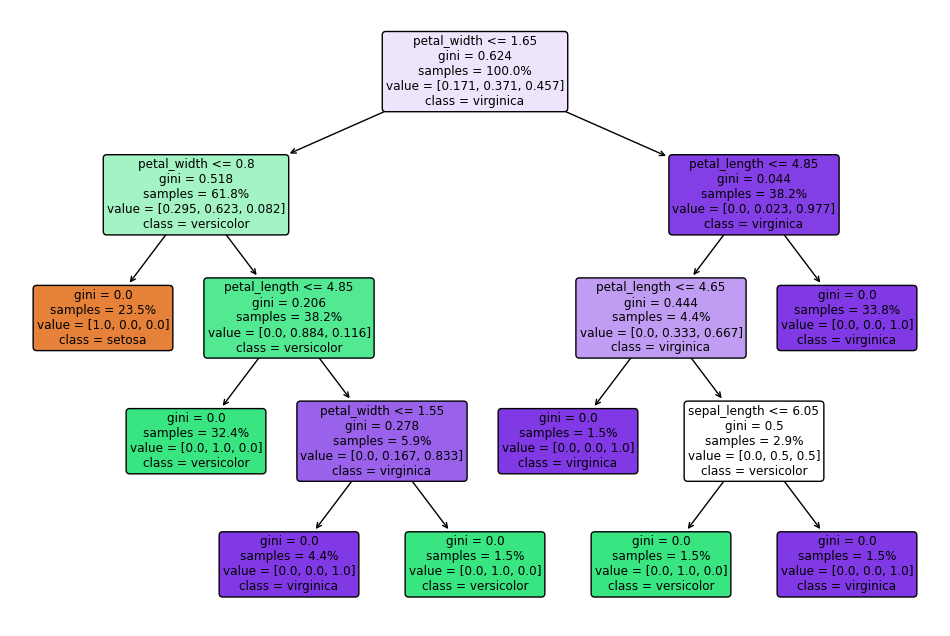

In [152]:
plt.figure(figsize=(12, 8))
plot_tree(rfclf_iris.estimators_[0], filled=True, feature_names=X_iris.columns, class_names=y_iris.unique(), rounded=True, proportion=True)
plt.show()

In [177]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

import dtreeviz

iris = load_iris()
X = iris.data
y = iris.target

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)

viz_model = dtreeviz.model(clf,
                           X_train=X, y_train=y,
                           feature_names=iris.feature_names,
                           target_name='iris',
                           class_names=iris.target_names)

viz_model.view()     # render as SVG into internal object 

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [123]:
generate_dynamic_rf_classifier_visualizer(rfclf_iris, X_train_iris, X_test_iris, y_train_iris, y_test_iris, 8062)

In [136]:
generate_dynamic_rf_classifier_visualizer(rfclf_bc, X_train_bc, X_test_bc, y_train_bc, y_test_bc, 8063)

In [143]:
generate_dynamic_rf_classifier_visualizer(rfclf_har, X_train_har, X_test_har, y_train_har, y_test_har, 8064)